# Clustering
Here we use the example of a finely discretized MSM to produce a small number of clusters using the method described by Buchete and Hummer. We build macrostates based on the sign or distribution of the eigenvector values.

* [Coarse Master Equations for Peptide Folding Dynamics](http://dx.doi.org/10.1021/jp0761665)
J. Phys. Chem. B 112 (19) 6057–6069 (2008).

As they stated in their paper, this approach is a version of Perron clustering
(i.e. PCCA). On top of the methods described in the reference above, and 
following work by [Chodera et al](http://dx.doi.org/10.1063/1.2714538) we 
include an optimization step in the clustering. This way, there is some chance 
that imperfections in the initial, eigenvector-based clustering, will be overcome. 
The optimization is a Monte Carlo simulated annealing procedure where the
 metastability plays the role of the energy and we use a simple temperature scheme.

In [1]:
%load_ext autoreload
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We start by importing the trajectory.

In [2]:
import mdtraj as md
from mastermsm.trajectory import traj
tr = traj.TimeSeries(top='data/alaTB.gro', traj=['data/protein_only.xtc'])
print tr.mdt

<mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells>


## Fine grid on the Ramachandran map
We start making a grid on the Ramachandran map with many (400) states. We plot the time-series data for the state assignment, which reveals hops in the discrete sate space.

In [3]:
tr.discretize(method="ramagrid", nbins=20)
tr.find_keys()

(-1, 400)

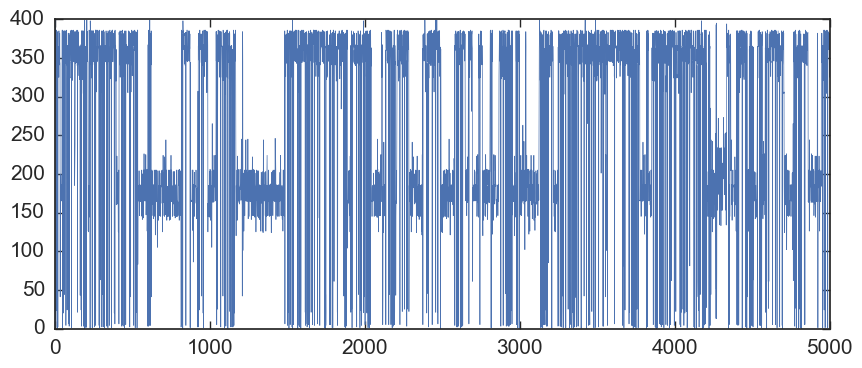

In [4]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot([x for x in tr.distraj], lw=0.5)
ax.set_xlim(0,5000)
ax.set_ylim(-1,400)

The next step is constructing the MSM using the `mastermsm.msm` module. We estimate eigenvalues and eigenvectors at different lag times, which results in rather stable relaxation times. Clearly there are two slow modes in the system, correponding to time-scales of ~70 and ~30 ps.

In [5]:
from mastermsm.msm import msm
msm_alaTB_grid = msm.SuperMSM([tr])
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_alaTB_grid.do_msm(i, sym=False)
    msm_alaTB_grid.msms[i].do_trans()


 Building MSM from 
[['data/protein_only.xtc']]
     # states: 197


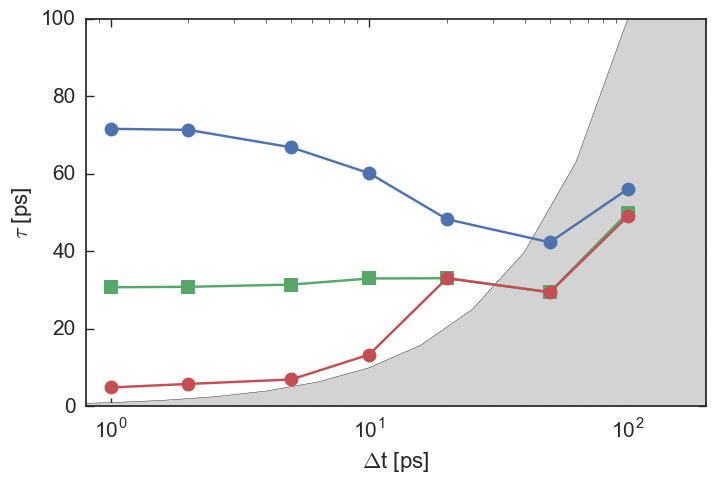

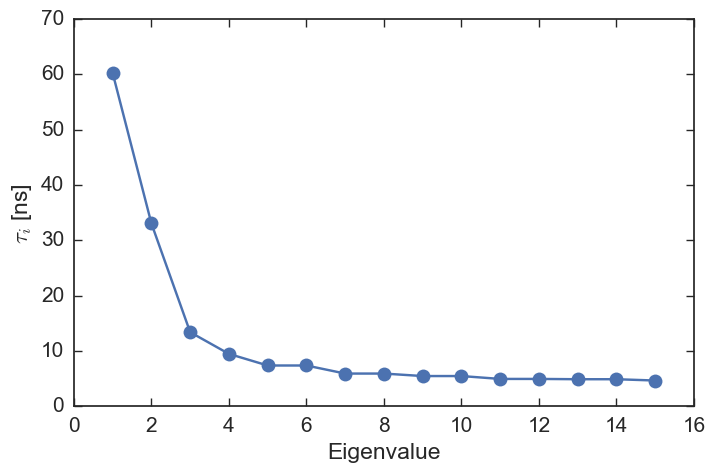

In [6]:
tau1_vs_lagt = np.array([[x,msm_alaTB_grid.msms[x].tauT[0]] \
               for x in sorted(msm_alaTB_grid.msms.keys())])
tau2_vs_lagt = np.array([[x,msm_alaTB_grid.msms[x].tauT[1]] \
               for x in sorted(msm_alaTB_grid.msms.keys())])
tau3_vs_lagt = np.array([[x,msm_alaTB_grid.msms[x].tauT[2]] \
               for x in sorted(msm_alaTB_grid.msms.keys())])

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(tau1_vs_lagt[:,0],tau1_vs_lagt[:,1],'o-', markersize=10)
ax.plot(tau2_vs_lagt[:,0],tau2_vs_lagt[:,1],'s-', markersize=10)
ax.plot(tau3_vs_lagt[:,0],tau3_vs_lagt[:,1],'o-', markersize=10)
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(0,100)
_ = ax.set_xscale('log')
#_ = ax.set_yscale('log')

fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(range(1,16),msm_alaTB_grid.msms[10].tauT[0:15], fmt='o-', ms=10)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$ [ns]')
#ax.set_yscale('log')

We can use the eigenvectors to understand what these slow modes correspond to. We find that the slowest mode corresponds to the exchange between the $3_{10}$ helix and the $\alpha$-helix, while the second slowest mode corresponds to the exchange between $\alpha$-helix and $\beta$/coil. 

In [7]:
msm_alaTB_grid.msms[2].do_trans(evecs=True)

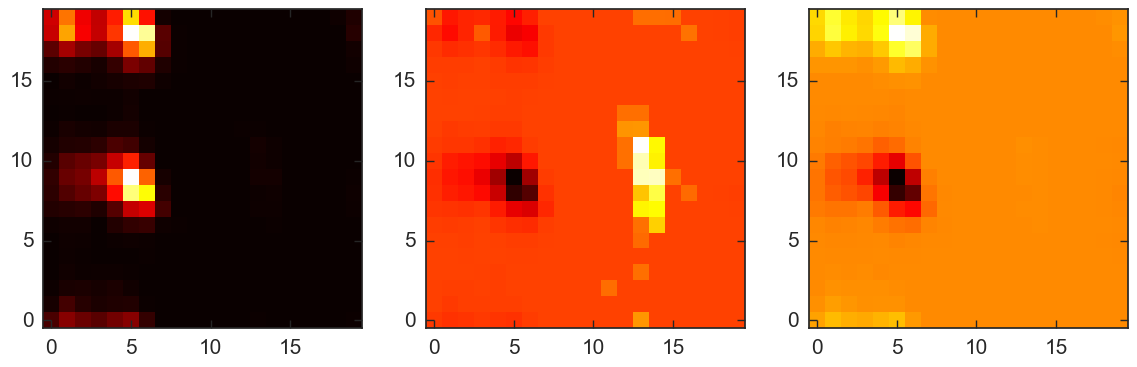

In [8]:
fig, ax = plt.subplots(1,3, figsize=(14,5))
mat = np.zeros((20,20), float)
for i in [x for x in zip(msm_alaTB_grid.msms[2].keep_keys, \
                         msm_alaTB_grid.msms[2].rvecsT[:,0])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%20, int(i[0]/20)] = i[1]
ax[0].imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap='hot')
mat = np.zeros((20,20), float)
for i in [x for x in zip(msm_alaTB_grid.msms[2].keep_keys, \
                         msm_alaTB_grid.msms[2].rvecsT[:,1])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%20, int(i[0]/20)] = -i[1]
ax[1].imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap='hot')
mat = np.zeros((20,20), float)
for i in [x for x in zip(msm_alaTB_grid.msms[2].keep_keys, \
                         msm_alaTB_grid.msms[2].rvecsT[:,2])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%20, int(i[0]/20)] = -i[1]
_ = ax[2].imshow(mat.transpose(), interpolation="none", origin='lower', \
                 cmap='hot')

## Clustering the MSM
We use the eigenvectors to partition the state space in clusters. For this we have to import the `pcca` module from `MasterMSM`. From the eigenvectors we are immediately able to produce a sensible, albeit still imperfect, partitioning in three states.

In [9]:
from mastermsm.pcca import pcca

In [10]:
msm_pcca3 = pcca.PCCA(msm_alaTB_grid.msms[2], N=3)


 Initial membership of microstates to macrostates:
0 : 78
1 : 24
2 : 95


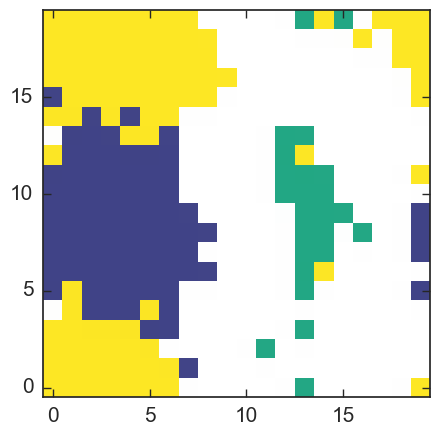

In [11]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(5,5))
mat = np.zeros((20,20), float)
for i in msm_alaTB_grid.msms[2].keep_keys:
    j = msm_alaTB_grid.msms[2].keep_keys.index(i)
    if j in msm_pcca3.macros[0]:
        mat[i%20, int(i/20)] = 1
    elif j in msm_pcca3.macros[1]:
        mat[i%20, int(i/20)] = 2
    else:
        mat[i%20, int(i/20)] = 3
    mat#print i, i[0]%20, int(i[0]/20), -i[1]
my_cmap = cm.get_cmap('viridis')
my_cmap.set_under('w')
ax.imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap=my_cmap, vmin = 0.5)

In [12]:
msm_pcca3.map_trajectory()


 Mapping trajectory onto macrostates...


After we have mapped our trajectories to the clusters, we can treat the PCCA model as a Markov state model, only with less states. The "metastability" is simple metric of how good our model is. It should be as close to the number of clusters as possible.

In [23]:
msm_pcca3.do_count()
msm_pcca3.do_trans()
msm_pcca3.do_rate()
msm_pcca3.metastability()

2.8758569128774205